In [1]:
%%javascript 
$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

from __future__ import division
from calculate_from_DOS import *
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.style.use('seaborn-notebook')

/Users/benjamin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Preamble and basic values

First, we can inspect the various constants to make sure they are correct. The effective mass in GaAs is $m^* = 0.067m_e$. The zero-field DOS, is given by the equation 

$\nu_0 = \frac{k_b m^*}{(\pi \hbar^2)} \, [K^{-1}m^{-2}]$

Note that the code treats energy in units of $k_b T$, hence the DOS is given per K rather than per J. 

In [3]:
print("Calculation: %.3e"%(k_b * m_star/ (pi * hbar**2)))
print("Hard-Coded: %.3e"%nu0)

Calculation: 2.412e+13
Hard-Coded: 2.412e+13


## Zero field calculations

As a first example let's calculate values for a flat density of states, corresponding to a non-interacting 2D electron gas in GaAs at zero magnetic field with density $3 \times 10^{15}m^{-2}$. We'll need to provide two arrays: $\epsilon$, the domain of energy over which to perform calculations, and $g$, the corresponding reduced density of states. To inform our choice of $\epsilon$, let's calculate the Fermi energy. 

In [4]:
n_e = 3e15
E_f = E_fermi(n_e)
print('Fermi energy is: %.3f'%E_f)

Fermi energy is: 124.387


For now, let's choose $\epsilon \,$ to span from 0 to 500, with 10000 points. Later, we can be more clever in order to perform faster calculations. Because the code uses the reduced DOS, we just need to provide a numpy array of ones as our DOS to perform calculations for zero field.

In [5]:
eps = np.linspace(0, 500, 10000)
dens = np.ones(len(eps))

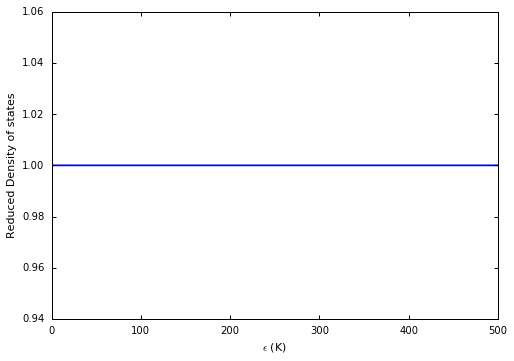

In [6]:
plt.plot (eps, dens)
plt.xlabel (r'$\epsilon$ (K)')
plt.ylabel (r'Reduced Density of states')

We can calculate the chemical potential, $\mu$, as a function of temperature. We expect it to be constant and equal to $E_f$ for $T << E_f$.

(0, 150)

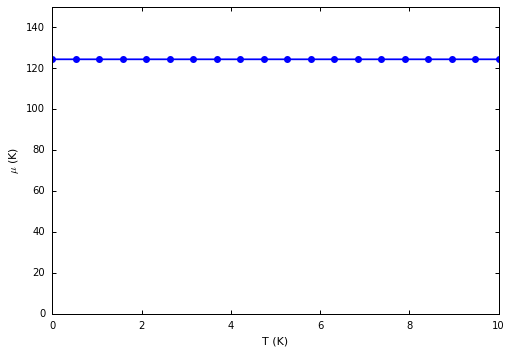

In [7]:
T_arr = np.linspace (0.001, 10, 20)
mu_arr = np.array([get_mu_at_T([eps, dens], T, n_e=n_e) for T in T_arr])
plt.plot(T_arr, mu_arr, 'o-b', mec = 'b')
plt.xlabel ('T (K)')
plt.ylabel ('$\mu$ (K)')
plt.ylim (0, 150)

## Conductivity

To calculate the conductivity, we need to know the transport lifetime. Let's assume our 2DEG has a mobility of $10^6 \,{\rm cm^2/V\dot s}$. The corresponding transport lifetime is given by

$\tau_{tr} = \frac{m^* \mu}{e}$

The equation used in sigma_DC is valid only for high magnetic field, so we can't proceed further with the calculation right now.

In [8]:
v_f = v_fermi(n_e)
tau_tr = m_star * 1e2/q_e
print("%.3f ps"%(tau_tr*1e12))
#print("sigma_DC = %.3f"%sigma_DC(0, tau_tr, v_f, q=q_e))

38.094 ps


## Specific heat

The specific heat can be calculated either for constant $\mu$ or constant $n_e$. With a flat density of states, these two are identical (since $\mu$ is independent of temperature even if $n_e$ is fixed). 

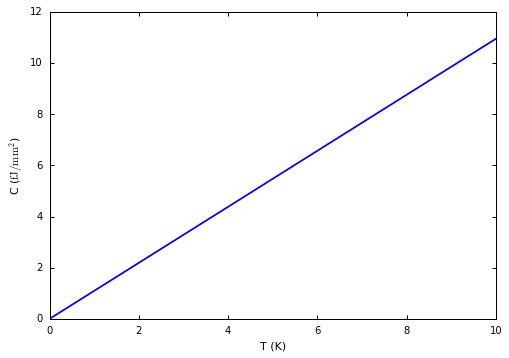

In [9]:
C_arr = np.array([specific_heat([eps, dens], T, mu=E_f, n_e=n_e) for T in T_arr])
plt.plot(T_arr, k_b * C_arr * 1e-6 * 1e15)
plt.xlabel ("T (K)")
plt.ylabel (r"C ($\rm fJ/mm^2$)")



Note that the calculation of C fails at T = 0, since there is a divide-by-zero error in the way it is calculates. However, you could take arbitrarily smalle values of T and find the limit as T approaches zero.

The specific heat can easily be calculated analytically as well, and the formula is

$C = \frac{\pi m^* k_b^2 T}{3 \hbar^2} \, {\rm \left[ \frac{J}{K \cdot m^2} \right]}$

Interestingly, $C$ is independent of the electron density. This is because $C$ depends only on the DOS near the chemical potential. Since the DOS is flat, even though $n_e$ changes $\mu$, the DOS looks the same locally.


In [10]:
C_0 = k_b * specific_heat([eps, dens], 1)
print 'Numerical: C/T = %.5e k_b'%C_0
print "Analytical: C/T = %.5e k_b"%(pi * m_star * k_b **2 / (3 * hbar **2))
print "Or in units of k_b/electron, for n_e = 3e15/m^2: C/T = %.5f "%(C_0/k_b/n_e)

Numerical: C/T = 1.09548e-09 k_b
Analytical: C/T = 1.09548e-09 k_b
Or in units of k_b/electron, for n_e = 3e15/m^2: C/T = 0.02645 


## Calculations in a Magnetic Field

To perform calculations in a magnetic field, we must first generate a DOS with Landau Levels. The generate_DOS function takes as one of its inputs $\tau_q$, the quantum lifetime, which is a measure of the Landau level broadening (via the Heisenberg uncertainty relation, $\Delta t \Delta E = \hbar$). This quantity is distinct from the transport lifetime, and may be extracted from a Dingle plot of the envelope of the low-field Shubnikov de Haas oscillations. Here, we use a typical order-of-magnitude value of 10 ps.

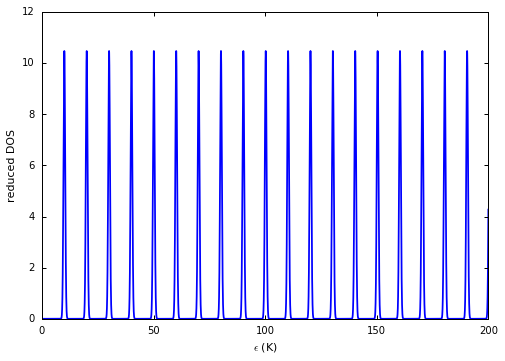

In [11]:
B = 0.5
tau_q = 5e-12
eps_B = np.linspace(0, 200, 10000)
eps_B, dens_B = generate_DOS(B, tau_q, eps=eps_B)
plt.plot (eps_B, dens_B)
plt.xlabel (r'$\epsilon$ (K)')
plt.ylabel ('reduced DOS')

From here, we can easily calculate specific heat and conductivity.

In [12]:
get_mu_at_T ([eps, dens], 1, n_e)

124.38774108886719

In [13]:
k_b * specific_heat([eps, dens], 1, n_e = 3.05e15)


1.0954848231065965e-09

In [14]:
k_b * specific_heat([eps, dens_B], 1, mu = 1)

2.5075567335599533e-16

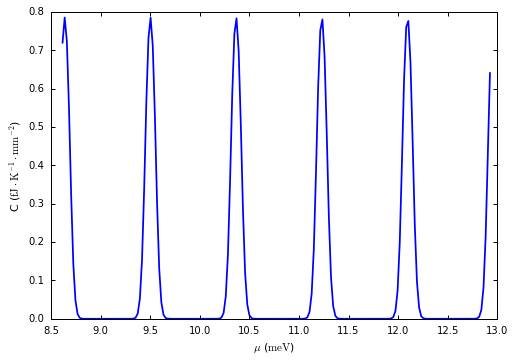

In [19]:
mu_arr_B = np.linspace (100, 150, 200)
C_arr_B = np.array([specific_heat([eps_B, dens_B], 0.1, mu, dT_frac = 0.001) for mu in mu_arr_B])
plt.plot (mu_arr_B * k_b / q_e * 1e3, k_b * C_arr_B *1e-6 * 1e15)
plt.xlabel (r'$\mu$ ($ \rm meV$)')
plt.ylabel (r'C ($\rm fJ\cdot K^{-1} \cdot mm^{-2}$)')

In [20]:
B_arr = np.linspace (0.01, 0.8, 1000)
T = 0.1
eps = generate_eps( T_low=T, T_high=T, n_e=n_e)
C_arr_B = np.array([specific_heat(generate_DOS(B_val, tau_q/5, eps=eps),
                                  T, E_f, dT_frac = 0.001) for B_val in B_arr])  

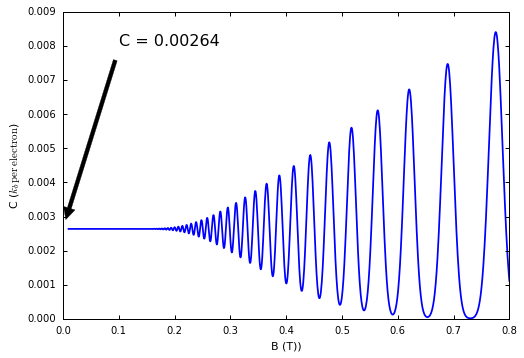

In [21]:
plt.plot (B_arr, C_arr_B/n_e)
plt.xlabel (r'B (T))')
plt.ylabel (r'C ($k_b {\rm \, per\, electron}$)')
plt.xlim(0, np.amax(B_arr)) 
plt.annotate("C = %.5f"%(C_0/k_b/n_e*T), [0, C_0/k_b/n_e*T], xytext =[0.1, 0.008],
             arrowprops=dict(facecolor='black', shrink=0.05))

The calculated specific heat extrapolates to the correct zero field value, and shows oscillations of increasing amplitude as the field increases.